In [392]:
#### Work in progress! ####

# Clustering
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance, distance_matrix
from matplotlib import pyplot as plt
import time

In [389]:
h = pd.read_csv("generate/user_history_0.csv")
e = pd.read_csv("generate/news_embedding.csv")
n = pd.read_csv("MINDlarge_train/news.tsv", sep="\t", header=None)  # For printing title when testing
i = pd.read_csv("generate/user_impressions_0.csv")
a = pd.read_csv("generate/news_cleaned.csv") # For publish dates

def readEmbeddings(history):
    
    # Create a dictionary with one item for each user
    # The dictionary item will contain a list where each item is a tuple (article info, a list of vectors)
    # The list of vectors has one item for each article present in the user's history
    
    uDict = {}
    for item in history.iterrows():
        uid = item[1][0]
        nid = item[1][1]
        dfRow = e[e["NID"]==nid]
        if not dfRow.empty:
            art = n[n[0]==nid]
            descr = str(art[1].values) + str(art[2].values) + str(art[3].values)
            embedding = (nid, descr, np.array(dfRow.iloc[0][1:].values))
            if uid in uDict:
                uDict[uid].append(embedding)
            else:
                uDict[uid] = [embedding]
        else:
            print(nid, end=" ")
    return uDict
                
def wardClustering(X):
    return linkage(X, "ward")

def getMedoidForCluster(members):
    D = distance_matrix(members, members)
    return np.argmin(D.sum(axis=0))

def getClusterScore(memberNumbers, articleItems):
    lam = 1E-8
    score = 0.0
    for c in memberNumbers:
        dfRow = a[a["NID"]==articleItems[c][0]]
        if not dfRow.empty:
            timestamp = dfRow["publishDate"].values[0]
            now = time.time()
            score += np.exp(-lam * (now - timestamp))
    return score

def getClosestArticle(medoid):
    minDist = 1e100
    for row in e.iterrows():
        v = np.array(np.array(row[1][1:]))
        d = distance.cosine(v, medoid)
        if d < minDist:
            minDist = d
            nid = row[1][0]
    return nid

def findRecommendationsForUser(uid, uDict, maxDistance):

    medoids = []
    scores = []
    
    # Extract embedding data for each read article and create one dataset for clustering
    items = uDict[uid]
    X = np.zeros((len(items), len(items[0][2])))
    for i, item in enumerate(items):
        X[i] = item[2]  # the third part of the tuple contains the vector (first part is article id and second the description)
    
    # Do the clustering
    linkage = wardClustering(X)
    clusterAssignment = fcluster(linkage, maxDistance, criterion='distance')
    print(clusterAssignment)
    print()
    
    # Process each cluster
    for c in range(1, max(clusterAssignment) + 1):
        
        clusterMembers = []
        memberNumbers = []
        
        # Extract the resulting embedding vectors for the cluster
        for i in range(len(items)):
            if clusterAssignment[i] == c:
                clusterMembers.append(X[i])
                memberNumbers.append(i)
                print(i, items[i][0], items[i][1])
        
        # Find the cluster medoid
        medoid = getMedoidForCluster(clusterMembers)
        index = memberNumbers[medoid]
        medoids.append(index)
        print("Medoid NID:",items[index][0], ", medoid index in list:", index)
        
        # Calculate the importance score of the cluster
        score = getClusterScore(memberNumbers, items)
        scores.append(score)
        print("Cluster score:",score)
        
        #TBD: use score to select clusters
        
        # Find the closest articles in the embedding space 
        nid = getClosestArticle(clusterMembers[medoid])
        print("Recommendation based on this cluster:", nid)
        art = n[n[0]==nid]
        print(art[1].values, art[2].values, art[3].values)
        print("====================================================")

        print()
    
    return linkage

N87236 N90686 N71166 N86208 N45698 N57459 N28668 N30865 N92279 N53611 N67998 N22090 N72271 N113547 N84362 N105813 N33543 N67397 N85659 N94639 N8308 N118038 N110630 N7149 N44584 N28385 N87731 N87654 [3 2 3 1 3 2 3 3 2 1 2 1 2 2]

3 N9740 ['news']['newscrime']['A Texas mom is going to prison after putting her son through unnecessary medical procedures']
9 N81970 ['lifestyle']['lifestyledidyouknow']['The oldest town in every state']
11 N98574 ['news']['newsworld']['Six deaths in one family over 14 years. Police say they have found their killer: The daughter-in-law.']
Medoid NID: N9740 , medoid index in list: 3
Cluster score: 1.6110607700029271
Recommendation based on this cluster: N31761
['travel'] ['traveltripideas'] ['This Dallas Garden Features 90,000 Pumpkins Each Fall']

1 N29136 ['lifestyle']['lifestylebuzz']["The First Full Look at Hailey Baldwin's Vera Wang Wedding Reception Dress Is Here"]
5 N52911 ['lifestyle']['lifestylebuzz']["Here's Jennifer Lopez Wearing the Most Extra Bejew

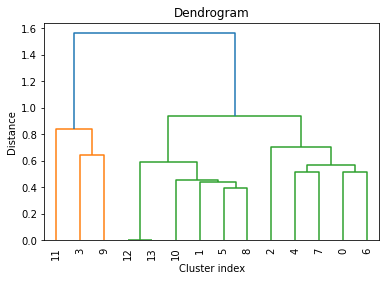

In [390]:
uDict = readEmbeddings(h[0:100])
uid = "U521853"
Z = findRecommendationsForUser(uid, uDict, 0.85)
plt.title("Dendrogram")
plt.xlabel("Cluster index")
plt.ylabel("Distance")
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,    # show only the last p merged clusters
    show_leaf_counts=False,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()